# Where to Open Coffee Shop in London 

In [1]:
!pip install geocoder
!pip install folium

     |████████████████████████████████| 98 kB 7.9 MB/s  eta 0:00:01
     |████████████████████████████████| 94 kB 4.9 MB/s  eta 0:00:01


# Methodology

In [2]:
#importing python packages 
import pandas as pd
import requests
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

# import k-means for the clustering stage
from sklearn.cluster import KMeans
import geocoder
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")


All Required Libraries Imported!


### Data Collection

In [3]:
#London areas from http
url_london = "https://en.wikipedia.org/wiki/List_of_areas_of_London"
wiki_london_url = requests.get(url_london)
wiki_london_url

<Response [200]>

In [4]:
#loading into data frame 
wiki_london_data = pd.read_html(wiki_london_url.text)
wiki_london_data = wiki_london_data[1]
wiki_london_data.head()

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


### Data Preprocessing and Cleaning 

In [5]:
#removing spaces in column titles 
#adding _ between words
wiki_london_data.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)

#only keeping and renaming columns with borough, town, and post_code info 
df1 = wiki_london_data.drop( [ wiki_london_data.columns[0], wiki_london_data.columns[4], wiki_london_data.columns[5] ], axis=1)
df1.columns = ['borough','town','post_code']
df1['borough'] = df1['borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))

#focusing on London within town column
df1 = df1[df1['town'].str.contains('LONDON')]

df1.head()

,borough,town,post_code
0,"Bexley, Greenwich",LONDON,SE2
1,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4"
6,City,LONDON,EC3
7,Westminster,LONDON,WC2
9,Bromley,LONDON,SE20


In [6]:
df1.shape

(308, 3)

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308 entries, 0 to 528
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   borough    308 non-null    object
 1   town       308 non-null    object
 2   post_code  308 non-null    object
dtypes: object(3)
memory usage: 9.6+ KB


## Creating Map of London

In [8]:
pip install arcgis

Note: you may need to restart the kernel to use updated packages.


In [9]:
#importing libraries 
from arcgis.geocoding import geocode
from arcgis.gis import GIS
gis = GIS()

#finding geocode for London
def get_x_y_uk(address1):
   lat_coords = 0
   lng_coords = 0
   g = geocode(address='{}, London, England, GBR'.format(address1))[0]
   lng_coords = g['location']['x']
   lat_coords = g['location']['y']
   return str(lat_coords) +","+ str(lng_coords)

In [11]:
#to later associate postal codes with lat/long
geo_coordinates_uk = df1['post_code']    

#finding latitude of London
coordinates_latlng_uk = geo_coordinates_uk.apply(lambda x: get_x_y_uk(x))
lat_uk = coordinates_latlng_uk.apply(lambda x: x.split(',')[0])

#finding longitude of London 
lng_uk = coordinates_latlng_uk.apply(lambda x: x.split(',')[1])

#merging lat/long into data set 
london_merged = pd.concat([df1,lat_uk.astype(float), lng_uk.astype(float)], axis=1)
london_merged.columns= ['borough','town','post_code','latitude','longitude']
london_merged

,borough,town,post_code,latitude,longitude
0,"Bexley, Greenwich",LONDON,SE2,51.49245,0.121270
1,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",51.51324,-0.267460
6,City,LONDON,EC3,51.51200,-0.080580
7,Westminster,LONDON,WC2,51.51651,-0.119680
9,Bromley,LONDON,SE20,51.41009,-0.056830
10,Islington,LONDON,"EC1, N1",51.52361,-0.098770
12,Islington,LONDON,N19,51.56393,-0.129450
14,Barnet,"BARNET, LONDON","EN5, NW7",51.61568,-0.245110
15,Enfield,LONDON,"N11, N14",51.63429,-0.133660
16,Wandsworth,LONDON,SW12,51.44822,-0.148390


In [265]:
#finding lat/long of London 
london = geocode(address='London, England, GBR')[0]
london_lng_coords = london['location']['x']
london_lat_coords = london['location']['y']
print("Longitude: ", london_lng_coords)
print("Latitude: ", london_lat_coords) 
lng=london_lng_coords
lat=london_lat_coords

Longitude:  -0.1272099999999341
Latitude:  51.50642000000005


### Map of London

In [13]:
# creating the map of London
map_London = folium.Map(location=[london_lat_coords, london_lng_coords], zoom_start=12)

# adding details to map
for latitude, longitude, borough, town in zip(london_merged['latitude'], london_merged['longitude'], london_merged['borough'], london_merged['town']):
    label = '{}, {}'.format(town, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True
        ).add_to(map_London)
    
map_London

## Data Preprocessing and Cleaning

In [14]:
#my foursquare data 
CLIENT_ID = 'DKOARQWWHD1CUVEREJJIQ0ZMMTYOEU5WMKVJIFXC5KOQUKQE' 
CLIENT_SECRET = 'AFMMJX2M4XX5QMWBPUFFYLQEF1ARAZAILHOCC3XG3Q5EEKAA'
ACCESS_TOKEN = 'X0W5V5RKT0ANHZOU1BY3CLWUJ5FSQI5AASQMDRY5YDVJB2KF' 
VERSION = '20180604'
LIMIT = 30

In [15]:
#using foursquare to get venue info (lat, long etc )
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
#saving boroughs, lat/long to varible 
venues_in_London = getNearbyVenues(london_merged['borough'], london_merged['latitude'], london_merged['longitude'])

Bexley, Greenwich 
Ealing, Hammersmith and Fulham
City
Westminster
Bromley
Islington
Islington
Barnet
Enfield
Wandsworth
Southwark
City
Richmond upon Thames
Barnet
Islington
Wandsworth
Westminster
Bromley
Newham
Ealing
Westminster
Lewisham
Camden
Southwark
Tower Hamlets
Bexley
City
Lewisham
Greenwich
Tower Hamlets
Camden
Haringey
Tower Hamlets
Haringey
Barnet
Brent
Lambeth
Lewisham
Tower Hamlets
Kensington and Chelsea, Hammersmith and Fulham
Brent
Barnet
Barnet
Southwark
Tower Hamlets
Camden
Tower Hamlets
Waltham Forest
Newham
Islington
Richmond upon Thames
Lewisham
Camden
Westminster
Greenwich
Kensington and Chelsea
Barnet
Westminster
Lewisham
Waltham Forest
Hounslow, Ealing, Hammersmith and Fulham
Brent
Barnet
Lambeth, Wandsworth
Islington
Barnet
Merton
Barnet
Westminster
Barnet, Brent, Camden
Lewisham
Bexley
Haringey
Bromley
Tower Hamlets
Newham
Hackney
Islington
Southwark
Lewisham
Brent
Southwark
Ealing
Kensington and Chelsea
Wandsworth
Southwark
Barnet
Newham
Richmond upon Thames


In [17]:
venues_in_London.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category
0,"Bexley, Greenwich",51.49245,0.12127,Lesnes Abbey,Historic Site
1,"Bexley, Greenwich",51.49245,0.12127,Sainsbury's,Supermarket
2,"Bexley, Greenwich",51.49245,0.12127,Lidl,Supermarket
3,"Bexley, Greenwich",51.49245,0.12127,Abbey Wood Railway Station (ABW),Train Station
4,"Bexley, Greenwich",51.49245,0.12127,Costcutter,Convenience Store


## Model Building: Descriptive Analytics 

In [18]:
#fixing columns for better clustering 
London_venue_cat = pd.get_dummies(venues_in_London[['Venue Category']], prefix="", prefix_sep="")

# moving/adding neighborhood column to the first column
London_venue_cat['Neighborhood'] = venues_in_London['Neighborhood'] 
fixed_columns = [London_venue_cat.columns[-1]] + list(London_venue_cat.columns[:-1])
London_venue_cat = London_venue_cat[fixed_columns]
London_grouped = London_venue_cat.groupby('Neighborhood').mean().reset_index()

London_venue_cat.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Camera Store,Canal,Candy Store,Caribbean Restaurant,Carpet Store,Caucasian Restaurant,Cemetery,Champagne Bar,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cricket Ground,Cupcake Shop,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Reservoir,Residential Building (Apartment / Condo),Restaurant,Sake Bar,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shaanxi Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stables,Stationery Store,Steakhouse,Street Food Gathering,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tour P

In [254]:
#locating most common venues with their rows; sorting 
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [255]:

num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns with top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [256]:
# create a new dataframe for London with new data
neighborhoods_venues_sorted_london = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_london['Neighborhood'] = London_grouped['Neighborhood']

#sorting for top venues 
for ind in np.arange(London_grouped.shape[0]):
    neighborhoods_venues_sorted_london.iloc[ind, 1:] = return_most_common_venues(London_grouped.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted_london


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barnet,Coffee Shop,Café,Grocery Store,Pub,Italian Restaurant,Bus Stop,Supermarket,Pharmacy,Turkish Restaurant,Bakery
1,"Barnet, Brent, Camden",Bus Stop,Bakery,Clothing Store,Supermarket,Gym / Fitness Center,Hardware Store,Zoo Exhibit,Filipino Restaurant,Exhibit,Falafel Restaurant
2,Bexley,Supermarket,Historic Site,Platform,Convenience Store,Train Station,Golf Course,Bus Stop,Construction & Landscaping,Park,Filipino Restaurant
3,"Bexley, Greenwich",Daycare,Construction & Landscaping,Food Service,Bus Stop,Golf Course,Park,Historic Site,Sports Club,Convenience Store,Diner
4,"Bexley, Greenwich",Supermarket,Train Station,Convenience Store,Historic Site,Platform,Zoo Exhibit,Film Studio,Event Space,Exhibit,Falafel Restaurant
5,Brent,Pharmacy,Discount Store,Fast Food Restaurant,Chinese Restaurant,Sandwich Place,Warehouse Store,Indian Restaurant,Pub,Convenience Store,Bed & Breakfast
6,"Brent, Camden",Indian Restaurant,Pub,Brazilian Restaurant,Café,Supermarket,Pharmacy,Grocery Store,Chinese Restaurant,Sandwich Place,Gastropub
7,"Brent, Ealing",Chinese Restaurant,Pharmacy,Fast Food Restaurant,Convenience Store,Warehouse Store,Discount Store,Bed & Breakfast,Sandwich Place,Event Space,Exhibit
8,"Brent, Harrow",Hotel,Monument / Landmark,Garden,Plaza,Theater,Cocktail Bar,Pub,Japanese Restaurant,Ramen Restaurant,Steakhouse
9,Bromley,Supermarket,Hotel,Fast Food Restaurant,Grocery Store,Convenience Store,Park,Pharmacy,Gastropub,Bistro,Sandwich Place


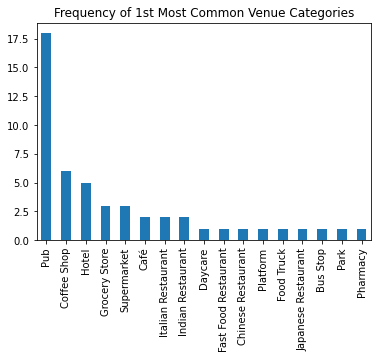

In [266]:
#bar graph of most common venue categories 
neighborhoods_venues_sorted_london['1st Most Common Venue'].value_counts().plot(kind='bar', title= 'Frequency of 1st Most Common Venue Categories')

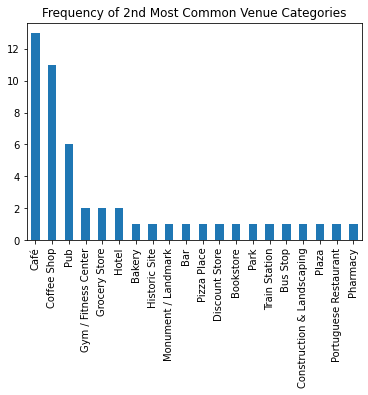

In [267]:
#bar graph of 2nd most common venue categories 
neighborhoods_venues_sorted_london['2nd Most Common Venue'].value_counts().plot(kind='bar', title= 'Frequency of 2nd Most Common Venue Categories')

# Model Building: Predictive Modeling 

## K-Means

In [269]:
# set number of clusters
k_num_clusters = 5

London_grouped_clustering = London_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans_london = KMeans(n_clusters=k_num_clusters, random_state=0).fit(London_grouped_clustering)
kmeans_london

KMeans(n_clusters=5, random_state=0)

In [270]:
#adding cluster labels
neighborhoods_venues_sorted_london.insert(0, 'Cluster Labels', kmeans_london.labels_ +1)
london_data = london_merged
london_data = london_data.join(neighborhoods_venues_sorted_london.set_index('Neighborhood'), on='borough')
london_data.head()

,borough,town,post_code,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bexley, Greenwich",LONDON,SE2,51.49245,0.12127,3,Supermarket,Train Station,Convenience Store,Historic Site,Platform,Zoo Exhibit,Film Studio,Event Space,Exhibit,Falafel Restaurant
1,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",51.51324,-0.26746,2,Grocery Store,Park,Breakfast Spot,Train Station,Indian Restaurant,Dessert Shop,Fish Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant
6,City,LONDON,EC3,51.51200,-0.08058,1,Hotel,Coffee Shop,Italian Restaurant,Gym / Fitness Center,Pub,Restaurant,Wine Bar,Sandwich Place,French Restaurant,Garden
7,Westminster,LONDON,WC2,51.51651,-0.11968,1,Hotel,Coffee Shop,Café,Pub,Sandwich Place,Italian Restaurant,Theater,Hotel Bar,Restaurant,Burger Joint
9,Bromley,LONDON,SE20,51.41009,-0.05683,1,Supermarket,Hotel,Fast Food Restaurant,Grocery Store,Convenience Store,Park,Pharmacy,Gastropub,Bistro,Sandwich Place


In [27]:
#dropping NaN values to prevent skewing
london_data_nonan = london_data.dropna(subset=['Cluster Labels'])

In [28]:
#counting 1st and 2nd most common venues listed together 
london_data_nonan.groupby(["borough", "1st Most Common Venue"]).size()

borough                                         1st Most Common Venue
Barnet                                          Coffee Shop              27
Barnet, Brent, Camden                           Bus Stop                  1
Bexley                                          Supermarket               4
Bexley, Greenwich                               Daycare                   2
Bexley, Greenwich                               Supermarket               1
Brent                                           Pharmacy                 11
Brent, Camden                                   Indian Restaurant         1
Brent, Ealing                                   Chinese Restaurant        1
Brent, Harrow                                   Hotel                     1
Bromley                                         Supermarket               5
Camden                                          Pub                      17
Camden, Islington                               Pub                       1
City              

In [29]:
#counting 1st and 2nd most common venues listed together 
london_data_nonan.groupby(["1st Most Common Venue", "2nd Most Common Venue"]).size()

1st Most Common Venue  2nd Most Common Venue     
Bus Stop               Bakery                         1
Café                   Coffee Shop                    1
                       Pub                           14
Chinese Restaurant     Pharmacy                       1
Coffee Shop            Bar                            5
                       Café                          35
                       Portuguese Restaurant          1
                       Pub                           28
Daycare                Construction & Landscaping     2
Fast Food Restaurant   Coffee Shop                    6
Food Truck             Coffee Shop                    1
Grocery Store          Café                           4
                       Park                           1
                       Pizza Place                    1
Hotel                  Coffee Shop                   22
                       Monument / Landmark            1
                       Plaza                          

In [30]:
#how many venues in each neighborhood 
london_data_nonan.groupby(["borough"]).size()

borough
Barnet                                            27
Barnet, Brent, Camden                              1
Bexley                                             4
Bexley, Greenwich                                  2
Bexley, Greenwich                                  1
Brent                                             11
Brent, Camden                                      1
Brent, Ealing                                      1
Brent, Harrow                                      1
Bromley                                            5
Camden                                            17
Camden, Islington                                  1
City                                               3
City, Westminster                                  1
Croydon                                            4
Ealing                                             4
Ealing, Hammersmith and Fulham                     1
Enfield                                            6
Greenwich                             

## Cluster Analysis 

In [31]:
#Cluster 1 with knn
london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 1, london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]]

,town,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,LONDON,1,Hotel,Coffee Shop,Italian Restaurant,Gym / Fitness Center,Pub,Restaurant,Wine Bar,Sandwich Place,French Restaurant,Garden
7,LONDON,1,Hotel,Coffee Shop,Café,Pub,Sandwich Place,Italian Restaurant,Theater,Hotel Bar,Restaurant,Burger Joint
9,LONDON,1,Supermarket,Hotel,Fast Food Restaurant,Grocery Store,Convenience Store,Park,Pharmacy,Gastropub,Bistro,Sandwich Place
10,LONDON,1,Coffee Shop,Pub,Food Truck,Café,Italian Restaurant,Vietnamese Restaurant,Park,Cocktail Bar,Gym / Fitness Center,Hotel
12,LONDON,1,Coffee Shop,Pub,Food Truck,Café,Italian Restaurant,Vietnamese Restaurant,Park,Cocktail Bar,Gym / Fitness Center,Hotel
14,"BARNET, LONDON",1,Coffee Shop,Café,Grocery Store,Pub,Italian Restaurant,Bus Stop,Supermarket,Pharmacy,Turkish Restaurant,Bakery
15,LONDON,1,Fast Food Restaurant,Coffee Shop,Supermarket,Pizza Place,Grocery Store,Gym / Fitness Center,Pub,Sandwich Place,Turkish Restaurant,Italian Restaurant
16,LONDON,1,Pub,Coffee Shop,Indian Restaurant,Bar,Supermarket,Café,Grocery Store,Portuguese Restaurant,Pharmacy,Pizza Place
17,LONDON,1,Pub,Café,Coffee Shop,Grocery Store,Park,Gym / Fitness Center,Pharmacy,Bar,Italian Restaurant,Bus Stop
18,LONDON,1,Hotel,Coffee Shop,Italian Restaurant,Gym / Fitness Center,Pub,Restaurant,Wine Bar,Sandwich Place,French Restaurant,Garden


In [215]:
df1=london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 1].pivot_table(index=['borough', "1st Most Common Venue", '2nd Most Common Venue'], aggfunc= 'size')
df1


borough                                         1st Most Common Venue  2nd Most Common Venue     
Barnet                                          Coffee Shop            Café                          27
Bexley, Greenwich                               Daycare                Construction & Landscaping     2
Brent                                           Pharmacy               Discount Store                11
Brent, Camden                                   Indian Restaurant      Pub                            1
Brent, Harrow                                   Hotel                  Monument / Landmark            1
Bromley                                         Supermarket            Hotel                          5
Camden                                          Pub                    Café                          17
Camden, Islington                               Pub                    Bookstore                      1
City                                            Hotel                 

In [33]:
#cluster 2
london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 2, london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]].head()

,town,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,LONDON,2,Grocery Store,Park,Breakfast Spot,Train Station,Indian Restaurant,Dessert Shop,Fish Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant


In [34]:
df2=london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 2].pivot_table(index=['borough', "1st Most Common Venue", '2nd Most Common Venue'], aggfunc= 'size')
df2

borough                         1st Most Common Venue  2nd Most Common Venue
Ealing, Hammersmith and Fulham  Grocery Store          Park                     1
dtype: int64

In [35]:
#cluster3
london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 3, london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]].head()

,town,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,LONDON,3,Supermarket,Train Station,Convenience Store,Historic Site,Platform,Zoo Exhibit,Film Studio,Event Space,Exhibit,Falafel Restaurant
45,"BEXLEYHEATH, LONDON",3,Supermarket,Historic Site,Platform,Convenience Store,Train Station,Golf Course,Bus Stop,Construction & Landscaping,Park,Filipino Restaurant
124,LONDON,3,Supermarket,Historic Site,Platform,Convenience Store,Train Station,Golf Course,Bus Stop,Construction & Landscaping,Park,Filipino Restaurant
291,"LONDON, SIDCUP",3,Supermarket,Historic Site,Platform,Convenience Store,Train Station,Golf Course,Bus Stop,Construction & Landscaping,Park,Filipino Restaurant
505,LONDON,3,Supermarket,Historic Site,Platform,Convenience Store,Train Station,Golf Course,Bus Stop,Construction & Landscaping,Park,Filipino Restaurant


In [36]:
df33=london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 3].pivot_table(index=['borough', "1st Most Common Venue", "2nd Most Common Venue"], aggfunc= 'size')
df33

borough             1st Most Common Venue  2nd Most Common Venue
Bexley              Supermarket            Historic Site            4
Bexley, Greenwich   Supermarket            Train Station            1
dtype: int64

In [37]:
#cluster 4
london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 4, london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]].head()

,town,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
356,LONDON,4,Chinese Restaurant,Pharmacy,Fast Food Restaurant,Convenience Store,Warehouse Store,Discount Store,Bed & Breakfast,Sandwich Place,Event Space,Exhibit


In [38]:
df4=london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 4].pivot_table(index=['borough', "1st Most Common Venue", "2nd Most Common Venue"], aggfunc= 'size')
df4

borough        1st Most Common Venue  2nd Most Common Venue
Brent, Ealing  Chinese Restaurant     Pharmacy                 1
dtype: int64

In [39]:
#cluster 5
london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 5, london_data_nonan.columns[[1] + list(range(5, london_data_nonan.shape[1]))]].head()

,town,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
121,LONDON,5,Bus Stop,Bakery,Clothing Store,Supermarket,Gym / Fitness Center,Hardware Store,Zoo Exhibit,Filipino Restaurant,Exhibit,Falafel Restaurant


In [40]:
df5=london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 5].pivot_table(index=["borough", "1st Most Common Venue", "2nd Most Common Venue"], aggfunc= 'size')
df5

borough                1st Most Common Venue  2nd Most Common Venue
Barnet, Brent, Camden  Bus Stop               Bakery                   1
dtype: int64

# Results

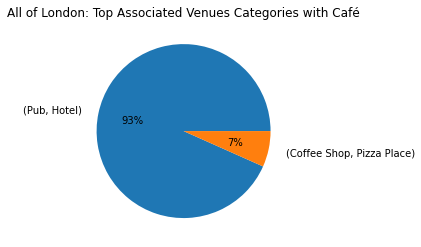

In [168]:
#venue categories most associated with cafe for all of London
conclusion1=london_data_nonan.loc[london_data_nonan["1st Most Common Venue"] == 'Café'].pivot_table(index=["2nd Most Common Venue", '3rd Most Common Venue'], aggfunc='size')
conclusion1.sort_values(ascending=False).head(10).plot(kind='pie', autopct='%1.0f%%', labeldistance=1.2, title='All of London: Top Associated Venues Categories with Café', label=(' '))

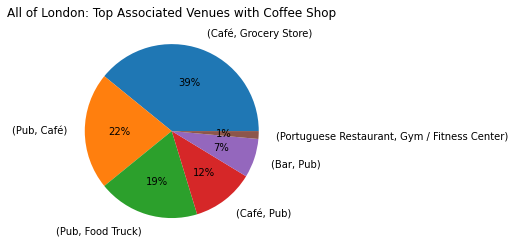

In [163]:
#venue categories most associated with coffee shop for all of London
conclusion2=london_data_nonan.loc[london_data_nonan["1st Most Common Venue"] == 'Coffee Shop'].pivot_table(index=["2nd Most Common Venue", '3rd Most Common Venue'], aggfunc='size')
conclusion2.sort_values(ascending=False).head(10).plot(kind='pie', autopct='%1.0f%%', labeldistance=1.2, title='All of London: Top Associated Venues with Coffee Shop', label=(' '))

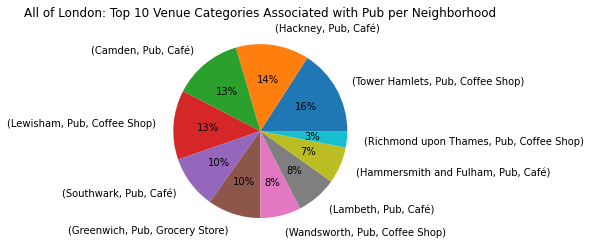

In [187]:
#finding which borough is best for coffee with pub as most common
conclusion3=london_data_nonan.loc[london_data_nonan["1st Most Common Venue"] == 'Pub'].pivot_table(index=["borough", '1st Most Common Venue', "2nd Most Common Venue"], aggfunc='size')
conclusion3.sort_values(ascending=False).head(10).plot(kind='pie', autopct='%1.0f%%', labeldistance=1.2, title='All of London: Top 10 Venue Categories Associated with Pub per Neighborhood', label=(' '))


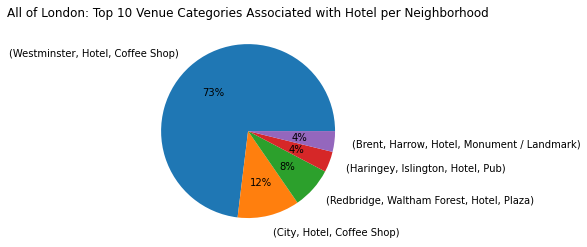

In [188]:
#finding which borough is best for coffee with hotel as most common 
conclusion4=london_data_nonan.loc[london_data_nonan["1st Most Common Venue"] == 'Hotel'].pivot_table(index=["borough", '1st Most Common Venue', "2nd Most Common Venue"], aggfunc='size')
conclusion4.sort_values(ascending=False).head(10).plot(kind='pie', autopct='%1.0f%%', labeldistance=1.2, title='All of London: Top 10 Venue Categories Associated with Hotel per Neighborhood', label=(' '))

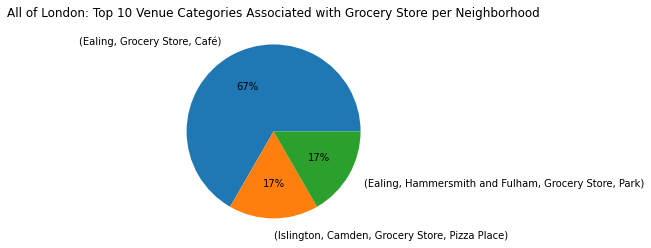

In [250]:
#finding which borough is best for coffee with hotel as most common 
conclusion5=london_data_nonan.loc[london_data_nonan["1st Most Common Venue"] == 'Grocery Store'].pivot_table(index=["borough", '1st Most Common Venue', "2nd Most Common Venue"], aggfunc='size')
conclusion5.sort_values(ascending=False).head(10).plot(kind='pie', autopct='%1.0f%%', labeldistance=1.2, title='All of London: Top 10 Venue Categories Associated with Grocery Store per Neighborhood', label=(' '))

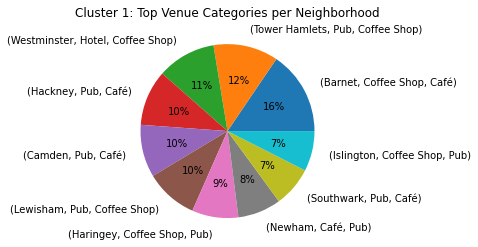

In [190]:
cluster1=london_data_nonan.loc[london_data_nonan['Cluster Labels'] == 1].pivot_table(index=['borough', "1st Most Common Venue", '2nd Most Common Venue'], aggfunc= 'size').sort_values(ascending=False).head(10).plot(kind='pie', autopct='%1.0f%%', labeldistance=1.2, title='Cluster 1: Top Venue Categories per Neighborhood', label=(' '))
cluster1